# 한글 폰트 설정
- 설치 후 세션 재시작

In [15]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [16]:
# import matplotlib.pyplot as plt
# plt.rc('font', family='NanumGothic')
# plt.rcParams['axes.unicode_minus'] =False

# 캘리포니아 집값 예측

## 1.라이브러리 임포트

In [17]:
# 필요한 라이브러리 임포트
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2.데이터 로드
- 각 피처의 의미
  1. `MedInc`: 지역의 중간 소득 (천 달러 단위)입니다.
  2. `HouseAge`: 주택 연령의 중앙값입니다.
  3. `AveRooms`: 평균 방 개수입니다.
  4. `AveBedrms`: 평균 침실 개수입니다.
  5. `Population`: 인구수입니다.
  6. `AveOccup`: 가구당 평균 거주자 수입니다.
  7. `Latitude`, `Longitude`: 주택 위치의 위도와 경도입니다.

- 종속변수 MEDV는 1000달러 단위의 주택 중위 값
  - Ex) 2.5 = 2만5천 달러

In [18]:
# 1. 데이터 로드
california = fetch_california_housing()

"""
DESCR : description의 줄임말
- Number of Instances: 20640     # 캘리포니아 집 20640 에 대한 데이터가 있음
- Number of Attributes: 8     # 입력 변수가 8개 있다는 것
"""

"""
print문에 대하여
- 텍스트 데이터의 모든 포맷팅 기호(줄바꿈, 탭, 공백) 등이 raw string으로 나타남
- print 문을 사용하면 텍스트 데이터를 사람이 읽기 쉽게 출력해줌
  e.g. print("Hello\nWorld!") 하면 \n은 출력되지 않음
"""
print(california.DESCR) 


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [19]:
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target, name='MEDV') #메드브이

In [20]:
# 위도와 경도 추가 (California Housing 데이터셋에는 포함)
X['Latitude'] = california.data[:, -2]
X['Longitude'] = california.data[:, -1]

In [21]:
# 데이터셋 확인 (상위 5개의 행을 출력)
print(X.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  


In [22]:
print(y)

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MEDV, Length: 20640, dtype: float64


## 3.EDA


### 1.데이터 구조 및 유형 확인


In [23]:
# 데이터 구조와 데이터 유형 확인
print(X.info())
print('-' * 40)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB
None
----------------------------------------


### 2.컬럼별 기초 통계량 확인

In [24]:
# 각 컬럼의 기초 통계량 확인
print(X.describe())

             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  
25%        2.429741     33.930000   -1

### 3.타겟 변수(MEDV)의 분포 확인
#### 해석:
   - `MEDV`는 중간 주택 가격을 나타내며, 약 0.5에서 5 사이의 값을 가짐.
   - 분포는 오른쪽 꼬리가 긴 비대칭 형태로 나타남.

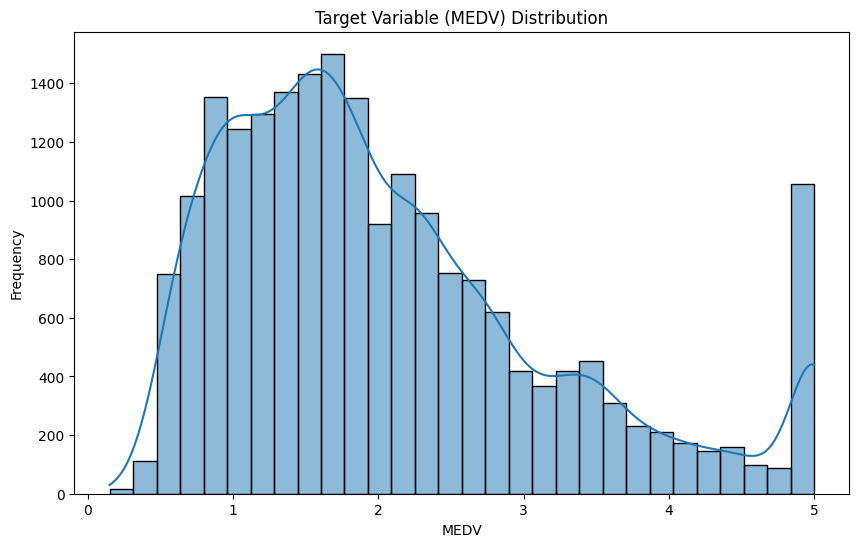

In [25]:
# 타겟 변수(MEDV)의 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=True)
plt.title('Target Variable (MEDV) Distribution')
plt.xlabel('MEDV')
plt.ylabel('Frequency')
plt.show()

### 4.위도와 경도에 따른 주택 가격 시각화
#### 해석 :
  - 주택 가격은 대체로 캘리포니아의 해안가 지역(특히, 남부와 북부 해안)에 집중되어 높게 나타남.
  - 내륙으로 갈수록 주택 가격이 낮아지는 경향이 있음.

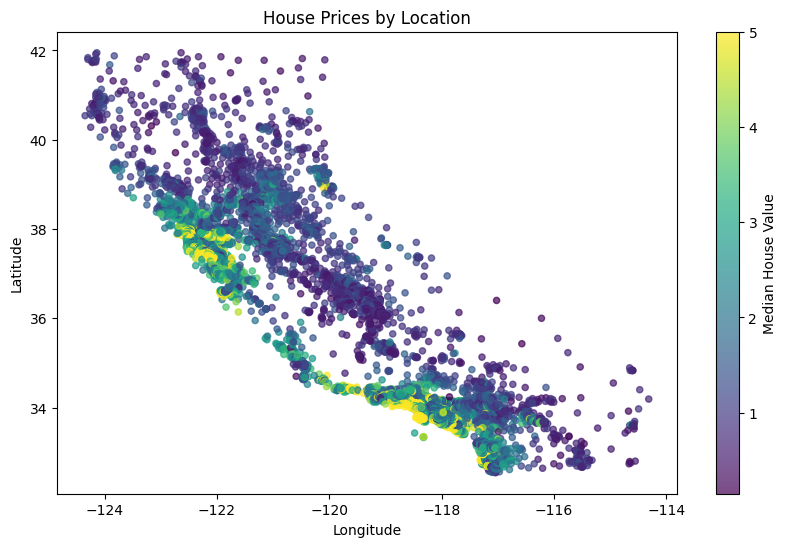

In [26]:
# 2.2. 위도와 경도에 따른 주택 가격 분포 시각화 (산점도)
plt.figure(figsize=(10, 6))
plt.scatter(X['Longitude'], X['Latitude'], c=y, cmap='viridis', s=20, alpha=0.7)
plt.colorbar(label='Median House Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('House Prices by Location')
plt.show()

# 해석:
# - 주택 가격은 대체로 캘리포니아의 해안가 지역(특히, 남부와 북부 해안)에 집중되어 높게 나타납니다.
# - 내륙으로 갈수록 주택 가격이 낮아지는 경향이 있습니다.

## 4.데이터 전처리
1. 데이터셋을 학습용와 테스트용으로 분리
2. 데이터 표준화 진행 (평균0, 표준편차1)


In [27]:
# 3. 데이터 전처리
# 훈련용과 테스트용 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 특성 스케일링 (표준화)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5.모델 학습

라쏘와 릿지에서의 알파값의 의미

Lasso :
  - 알파가 0인 경우 : 라쏘 회귀는 기본 선형 회귀와 동일하게 작동하며, 정규화가 적용되지 않음.
  - 알파가 1인 경우 : 더 많은 가중치가 0이 되며, 모델이 더 간단해지고 과적합의 위험이 줄어든다. 하지만 너무 큰 알파 값은 모델이 과소적합될 위험이 있음.
  
Ridge :
  - 알파가 0인 경우 : 모델은 기본 선형 회귀와 동일하게 작동하며, 정규화가 적용되지 않음.
  - 알파가 1인 경우 : 정규화 강도가 강해져, 가중치가 더 많이 축소됨. 이는 모델의 복잡성을 줄이고 과적합을 방지할 수 있지만, 너무 큰 알파 값은 모델이 과소적합될 위험이 있음.

cross_val_score() 파라미터 :
  - estimator: 평가할 모델(예: LinearRegression(), SVC() 등).
  - X: 특성 데이터(입력 데이터).
  - y: 타겟 데이터(출력 데이터).
  - scoring: 성능을 평가할 지표(예: 'accuracy', 'neg_mean_squared_error', 'f1', 등). 'neg_mean_squared_error'는 MSE의 음수를 반환합니다.
  - cv: 폴드 수(k값, 기본값은 5). cv=5는 5-폴드 교차 검증을 의미합니다.
  - n_jobs: 교차 검증을 병렬로 수행할 때 사용할 CPU 코어 수. n_jobs=-1로 설정하면 모든 코어를 사용합니다.

In [28]:
# 4. 모델 학습 및 비교
models = [
    ("Linear Regression", LinearRegression()),
    ("Lasso Regression", Lasso(alpha=0.1)),
    ("Ridge Regression", Ridge(alpha=1))
]

results = {}
for name, model in models:
    model.fit(X_train_scaled, y_train)
    scores = cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)
    rmse = np.sqrt(-scores)
    results[name] = rmse.mean()
    print(f"{name} RMSE: {rmse.mean()}")


Linear Regression RMSE: 0.7205271873526421
Lasso Regression RMSE: 0.819769043772667
Ridge Regression RMSE: 0.7205273313349767


## 모델 선정 및 시각화


최적의 모델은 Linear Regression입니다.


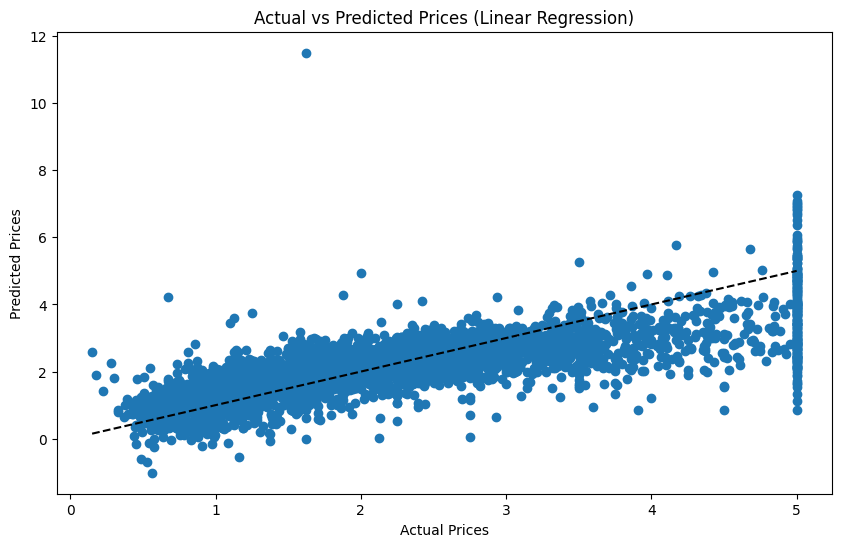

최종 모델 (Linear Regression)의 테스트 데이터 RMSE: 0.7455813830127764


In [29]:
# 5. 최종 모델 선택 및 결과 확인
best_model_name = min(results, key=results.get)
best_model = [model for name, model in models if name == best_model_name][0]

print(f"\n최적의 모델은 {best_model_name}입니다.")
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

# 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.title(f'Actual vs Predicted Prices ({best_model_name})')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()

# 최종 모델의 성능 평가
from sklearn.metrics import mean_squared_error
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"최종 모델 ({best_model_name})의 테스트 데이터 RMSE: {final_rmse}")
